<a href="https://colab.research.google.com/github/ashraful005/DS_ML_Bootcamp/blob/master/Fish_Disease_Detection_77and%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Install packages**

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
%%capture
!pip install torchmetrics
!pip install torchinfo

# **2. Import libraries**

In [75]:
# Data handling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Preprocessing
import cv2
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet50, ResNet50_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# typing
from typing import Dict, List

# Counter
from collections import Counter

# random
import random

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [76]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ashraful005","key":"4f746c27dab22414e17a0f5a0fe3baca"}'}

In [77]:
!pip install kaggle

In [78]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [79]:
!cp kaggle.json ~/.kaggle

In [80]:
!chmod 600 ~/.kaggle/kaggle.json

In [81]:
pip install --upgrade kaggle


In [82]:
!chmod 600 ~/.kaggle/kaggle.json

In [83]:
!kaggle datasets list

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                                     Apple Quality                                      170KB  2024-01-11 14:31:07           6780        162  1.0              
saimondahal/life-expectancy-trends-for-males-and-females           Life Expectancy Trends for Males and Females       263KB  2024-01-28 09:26:09            774         28  1.0              
hummaamqaasim/jobs-in-data                                         Jobs and Salaries in Data Science                   76KB  2023-12-25 20:03:32          13042        239  1.0              
yashusinghal/electric-vehicle-population-dataset  

In [84]:
!kaggle datasets download 'subirbiswas19/freshwater-fish-disease-aquaculture-in-south-asia'

freshwater-fish-disease-aquaculture-in-south-asia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [85]:
!unzip freshwater-fish-disease-aquaculture-in-south-asia.zip

Archive:  freshwater-fish-disease-aquaculture-in-south-asia.zip
replace SB-Fish-Disease.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [86]:
import pandas as pd

In [87]:
df=pd.read_csv('SB-Fish-Disease.csv')

In [88]:
df

Folder Name  \
0    Bacterial diseases - Aeromoniasis   
1    Bacterial diseases - Aeromoniasis   
2    Bacterial diseases - Aeromoniasis   
3    Bacterial diseases - Aeromoniasis   
4    Bacterial diseases - Aeromoniasis   
..                                 ...   
513  Viral diseases White tail disease   
514  Viral diseases White tail disease   
515  Viral diseases White tail disease   
516  Viral diseases White tail disease   
517  Viral diseases White tail disease   

                                 Image Filename  \
0    Bacterial diseases - Aeromoniasis (1).jpeg   
1     Bacterial diseases - Aeromoniasis (1).jpg   
2     Bacterial diseases - Aeromoniasis (1).png   
3    Bacterial diseases - Aeromoniasis (10).jpg   
4    Bacterial diseases - Aeromoniasis (11).jpg   
..                                          ...   
513   Viral diseases White tail disease (7).jpg   
514  Viral diseases White tail disease (8).jpeg   
515   Viral diseases White tail disease (8).jpg   
516  Viral diseases White tail disease (9).jpeg   
517   Viral diseases White tail disease (9).jpg   

                                            Image Path  
0    SB-FishDisease\Bacterial diseases - Aeromonias...  
1    SB-FishDisease\Bacterial diseases - Aeromonias...  
2    SB-FishDisease\Bacterial diseases - Aeromonias...  
3    SB-FishDisease\Bacterial diseases - Aeromonias...  
4    SB-FishDisease\Bacterial diseases - Aeromonias...  
..                                                 ...  
513  SB-FishDisease\Viral diseases White tail disea...  
514  SB-FishDisease\Viral diseases White tail disea...  
515  SB-FishDisease\Viral diseases White tail disea...  
516  SB-FishDisease\Viral diseases White tail disea...  
517  SB-FishDisease\Viral diseases White tail disea...  

[518 rows x 3 columns]

# **3. Load data and EDA**

In [89]:
# Let's see how many images we have.
from pathlib import Path
IMAGE_PATH = Path("/content/SB-FishDisease/SB-FishDisease")

image_path_list_jpg = list(IMAGE_PATH.glob("*/*.jpg"))
image_path_list_jpeg = list(IMAGE_PATH.glob("*/*.jpeg"))
image_path_list_png = list(IMAGE_PATH.glob("*/*.png"))
image_path_list_JPG = list(IMAGE_PATH.glob("*/*.JPG"))
image_path_list_webp = list(IMAGE_PATH.glob("*/*.webp"))

TOTAL_IMAGE_PATH_LIST = image_path_list_jpg + image_path_list_jpeg + image_path_list_png\
                        + image_path_list_JPG + image_path_list_webp

print(f'Total Images = {len(TOTAL_IMAGE_PATH_LIST)}')

Total Images = 460


In [90]:
# Let's visualize how many classes we have.
import os
classes = sorted(os.listdir(IMAGE_PATH))
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [91]:
# Let's see how many images per class we have.
from collections import Counter
class_count = []
for i in TOTAL_IMAGE_PATH_LIST:
    class_count.append(i.parent.stem)

Counter(class_count)

Counter({'Bacterial Red disease': 48,
         'Parasitic diseases': 38,
         'Healthy Fish': 177,
         'Bacterial gill disease': 58,
         'Fungal diseases Saprolegniasis': 46,
         'Viral diseases White tail disease': 44,
         'Bacterial diseases - Aeromoniasis': 49})

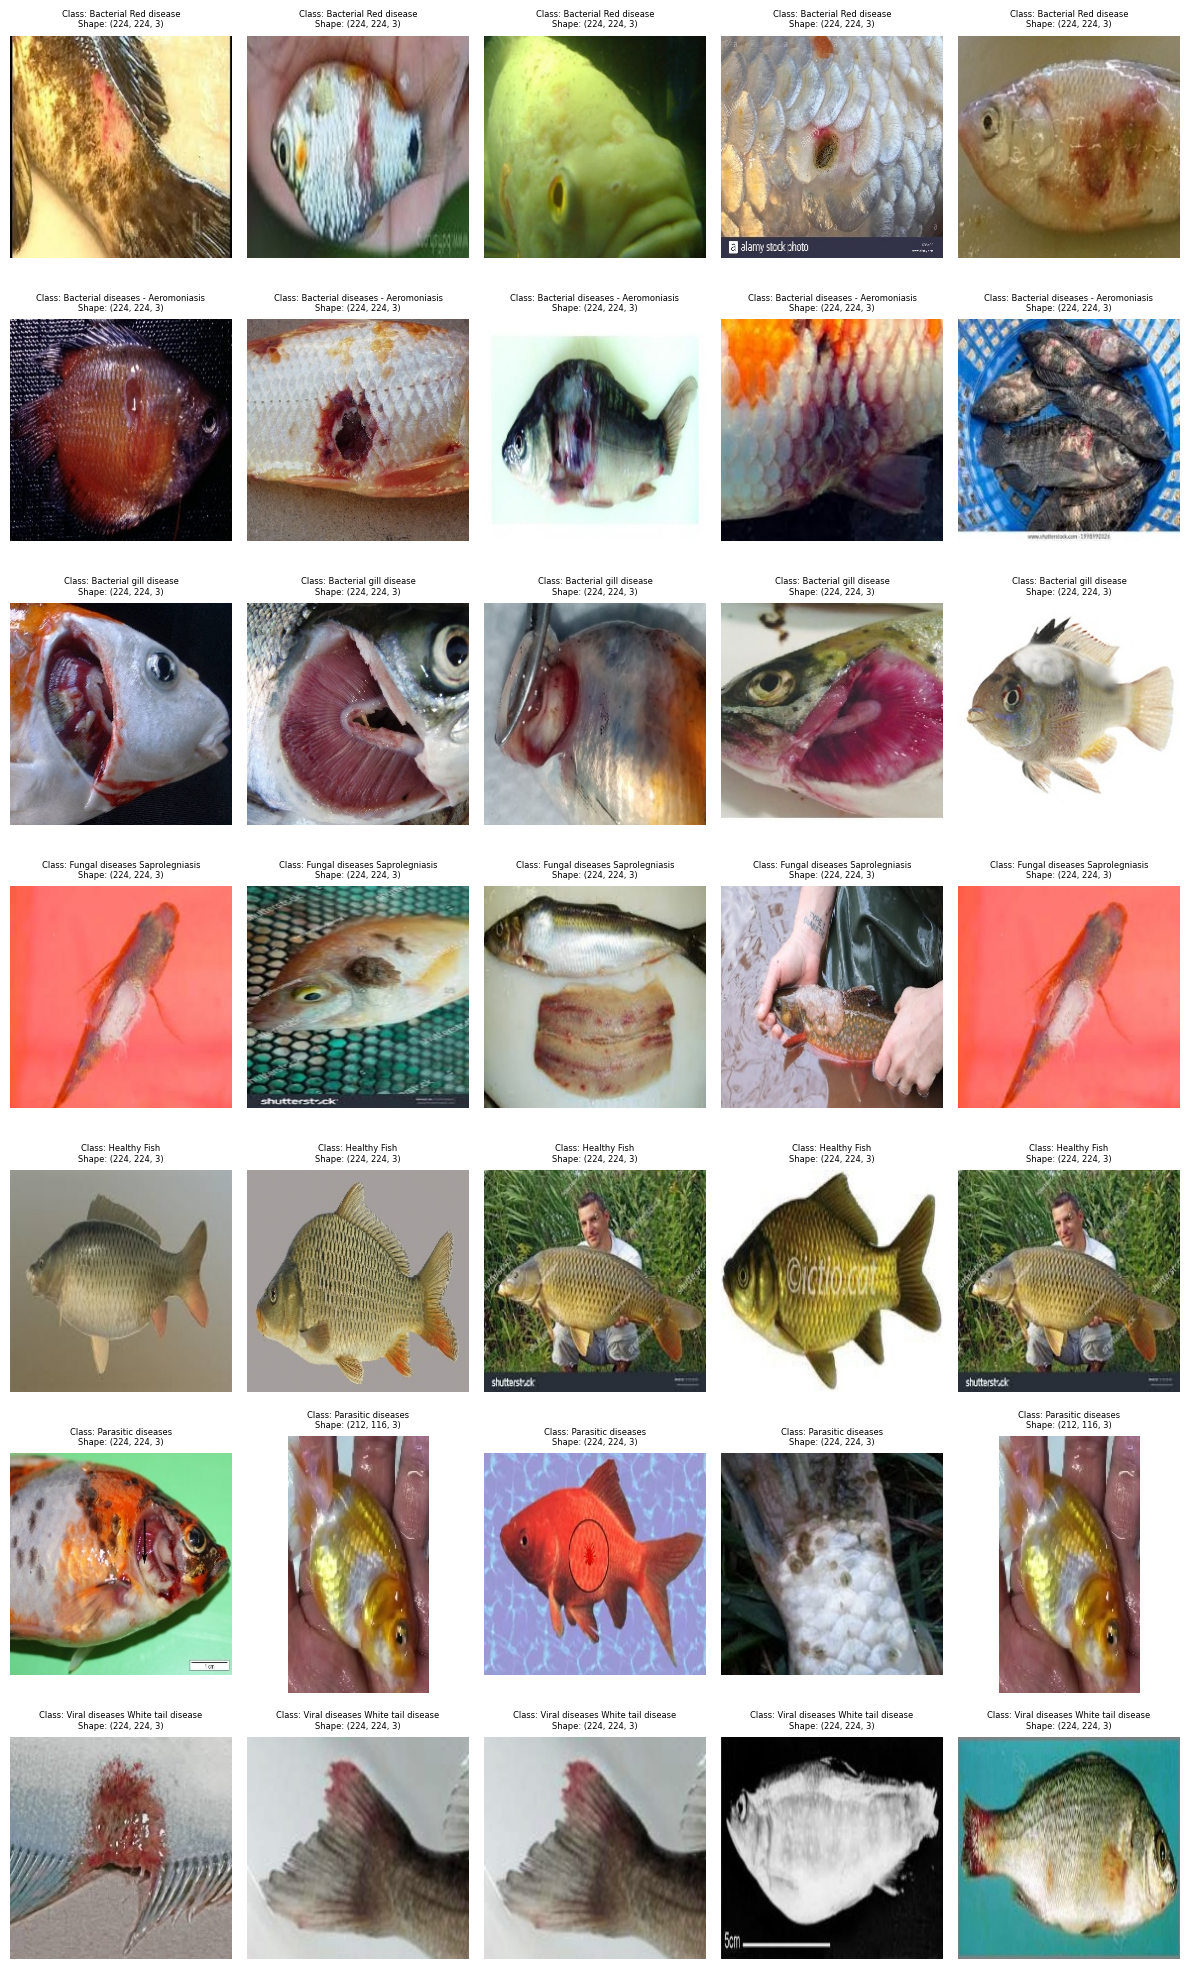

In [92]:
# Let's visualize 5 images for each class.
import matplotlib.pyplot as plt
import random
import cv2

fig,ax = plt.subplots(nrows = 7, ncols = 5, figsize = (12,20))
p = 0
for c in classes:

    a = random.choices(list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg")), k = 5)

    for i,j in enumerate(a):
        img_BGR = cv2.imread(str(j))
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_RGB)
        ax[p,i].set_title(f'Class: {j.parent.stem}\nShape: {img_RGB.shape}', fontsize = 6)
        ax[p,i].axis('off')
    p += 1

fig.tight_layout()
fig.show()

**We see that the images have different sizes, so we will proceed to see how the width and height of the images are distributed.**

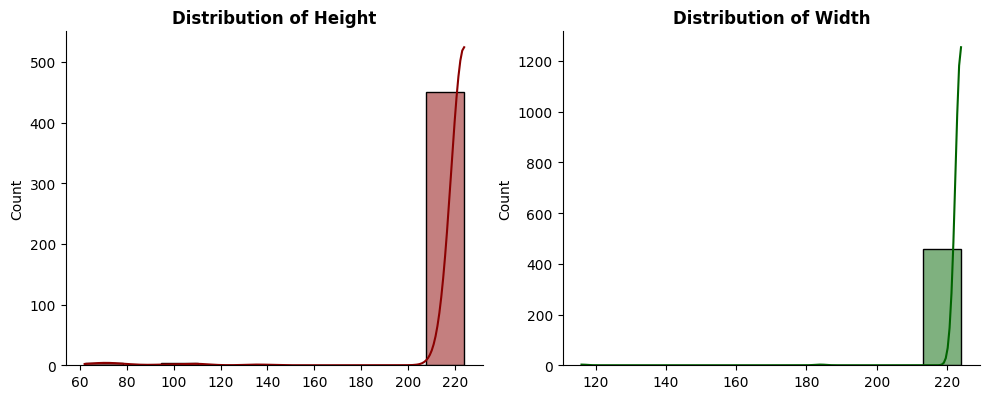

In [93]:
seq_height = []
seq_width = []

for i in TOTAL_IMAGE_PATH_LIST:
    img_BGR = cv2.imread(str(i))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    seq_height.append(img_RGB.shape[0])
    seq_width.append(img_RGB.shape[1])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.1))
ax = ax.flat

sns.histplot(seq_height, kde = True, color = 'darkred', ax = ax[0])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title('Distribution of Height', fontweight = 'bold', color = 'black')

sns.histplot(seq_width, kde = True, color = 'darkgreen', ax = ax[1])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title('Distribution of Width', fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [94]:
df_height_width = pd.DataFrame({'height':seq_height, 'width':seq_width})

df_height_width.describe().T

count        mean        std    min    25%    50%    75%    max
height  460.0  221.345652  18.914556   62.0  224.0  224.0  224.0  224.0
width   460.0  223.678261   5.365991  116.0  224.0  224.0  224.0  224.0

# **4. Preprocessing**

In [95]:
# Let's create our pd.DataFrame to store the path of the images and their respective label.
img_path_and_label = {'img_path':[],
                      'label':[]}

for img_pth in TOTAL_IMAGE_PATH_LIST:
    img_path_and_label['img_path'].append(img_pth)
    img_path_and_label['label'].append(img_pth.parent.stem)

df_path_and_label = pd.DataFrame(img_path_and_label)
df_path_and_label.head()

img_path                  label
0  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial Red disease
1  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial Red disease
2  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial Red disease
3  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial Red disease
4  /content/SB-FishDisease/SB-FishDisease/Bacteri...  Bacterial Red disease

In [96]:
# Now we are going to separate the paths of the images and their respective label.
X = df_path_and_label.drop('label', axis = 1)
y = df_path_and_label['label']

# Then, let's split into training and test set.
# But first we define the random seed for reproducibility.
SEED = 42

X_train, X_test, y_train, y_test = tts(X,y, test_size = 0.2, random_state = SEED, stratify = y)

In [97]:
print('Total Images of training set:')
print(Counter(y_train))
print('')

print('Total Images of test set:')
print(Counter(y_test))

Total Images of training set:
Counter({'Healthy Fish': 142, 'Bacterial gill disease': 46, 'Bacterial diseases - Aeromoniasis': 39, 'Bacterial Red disease': 39, 'Fungal diseases Saprolegniasis': 37, 'Viral diseases White tail disease': 35, 'Parasitic diseases': 30})

Total Images of test set:
Counter({'Healthy Fish': 35, 'Bacterial gill disease': 12, 'Bacterial diseases - Aeromoniasis': 10, 'Viral diseases White tail disease': 9, 'Fungal diseases Saprolegniasis': 9, 'Bacterial Red disease': 9, 'Parasitic diseases': 8})


In [98]:
classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [99]:
# Now we have to convert our labels to number, where:
# Bacterial Red disease = 0
# Bacterial diseases - Aeromoniasis = 1
# Bacterial gill disease = 2
# Fungal diseases Saprolegniasis = 3
# Healthy Fish = 4
# Parasitic diseases = 5
# Viral diseases White tail disease = 6

label_map = dict(zip(classes, range(0,7)))

y_train_array = np.array(y_train.map(label_map))
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map))
y_test_torch = torch.from_numpy(y_test_array)
y_test_torch

tensor([4, 1, 2, 5, 4, 4, 1, 5, 6, 3, 4, 3, 4, 4, 0, 1, 4, 3, 6, 5, 0, 4, 3, 0,
        2, 2, 1, 5, 4, 6, 2, 6, 4, 1, 1, 4, 3, 2, 4, 4, 3, 1, 4, 4, 0, 0, 4, 4,
        5, 0, 2, 4, 2, 2, 4, 1, 6, 4, 4, 1, 4, 4, 3, 5, 0, 6, 3, 4, 6, 4, 4, 4,
        4, 2, 4, 2, 4, 5, 4, 3, 4, 1, 6, 0, 4, 6, 2, 4, 4, 5, 0, 2])

In [100]:
# We define the transformations for our data set.
weights = ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [101]:
# We apply the transformations to our data sets.

images_train = [None] * len(X_train)

for i, (_,img_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(img_path_train[0]).convert('RGB')
    images_train[i] = auto_transforms(img_train)

images_test = [None] * len(X_test)

for i, (_, img_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(img_path_test[0]).convert('RGB')
    images_test[i] = auto_transforms(img_test)

In [102]:
# We will then convert our lists of tensors into a single tensor.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

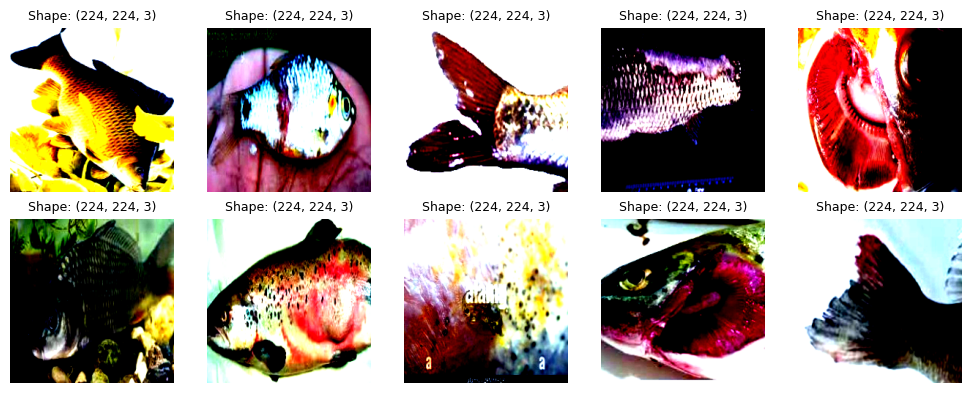

In [103]:
# Let's visualize some randomly selected transformed images.
indices = torch.randperm(10).numpy()

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4))
ax = ax.flat

for i,j in enumerate(indices):
    IMG = X_train_torch[j].permute(1,2,0).numpy()
    ax[i].imshow(IMG)
    ax[i].set_title(f'Shape: {IMG.shape}', fontsize = 9)
    ax[i].axis('off')

fig.tight_layout()
fig.show()

**Now we have to convert our tensors into Datase's and then convert it into DataLoader's.**

In [104]:
# First of all, we convert to Dataset but for this we have to create a Dataset class.
class CustomDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]

        return x,y

In [105]:
# Now we convert to Dataset.
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [106]:
# Then we convert to DataLoader.
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS)

In [107]:
# Let's visualize a batch.
images_batch, labels_batch = next(iter(train_dataloader))

images_batch.shape, labels_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

# **5. Model**

In [108]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [154]:
# We define the model to use.
#model = resnet50(weights = weights)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from keras.models import Sequential

num_classes = 7  # Replace with your actual number of classes
# Define your ResNet-50 model
#model = resnet50(weights = weights)
model = models.resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(1)  # Change to AdaptiveAvgPool2d to ensure fixed output size
#from keras.models import Sequential
#from keras.layers import Dense, Activation

# Experiment with different model architectures
#model = models.resnet34(pretrained=True)  # Try using a simpler model like resnet34
#model.fc = nn.Linear(model.fc.in_features, num_classes)


# Create a Sequential model
#model = Sequential()

# Add layers to the model
#model.add(Dense(units=64, input_dim=100))
#model.add(Activation('relu'))
#model.add(Dense(units=10))
#model.add(Activation('softmax'))


#model.layers[0].trainable = False
num_classes = 7  # Replace with your actual number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
#model = nn.Linear(model.in_features, num_classes)
# Add data augmentation to your image transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



In [110]:
# Now we visualize the architecture of the model.
!pip install torchinfo
from torchinfo import summary
summary(model = model,
        input_size = [4,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 7]            --                True
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] 128               True
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   4,096             True
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   128               True

In [111]:
# Now we freeze the parameters of the extractor layers.
# Add dropout to the fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(0.3),  # Adjust the dropout rate as needed
    nn.Linear(model.fc.in_features, num_classes)
)


In [112]:
# We go back to visualize how it looked after freezing the parameters.
# Now we visualize the architecture of the model.
#!pip install torchinfo
from torchinfo import summary
summary(model = model,
        input_size = [4,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])


Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 7]            --                True
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] 128               True
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   4,096             True
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   128               True

In [113]:
# Let's visualize the last layer, which we will modify for our binary classification purpose.
model.fc

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=7, bias=True)
)

In [114]:
# We modify the last layer.
output_shape = len(classes)

model.fc = nn.Linear(in_features = 2048, out_features = output_shape, bias = True)

In [115]:
# We visualize our model again.
summary(model = model,
        input_size = [4,3,224,224],
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width = 17,
        row_settings = ['var_names'])

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
ResNet (ResNet)                          [4, 3, 224, 224]  [4, 7]            --                True
├─Conv2d (conv1)                         [4, 3, 224, 224]  [4, 64, 112, 112] 9,408             True
├─BatchNorm2d (bn1)                      [4, 64, 112, 112] [4, 64, 112, 112] 128               True
├─ReLU (relu)                            [4, 64, 112, 112] [4, 64, 112, 112] --                --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112] [4, 64, 56, 56]   --                --
├─Sequential (layer1)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    └─Bottleneck (0)                    [4, 64, 56, 56]   [4, 256, 56, 56]  --                True
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]   [4, 64, 56, 56]   4,096             True
│    │    └─BatchNorm2d (bn1)            [4, 64, 56, 56]   [4, 64, 56, 56]   128               True

In [116]:
# Now let's visualize one step forward.

pred_logit = model(images_batch.to(device))
pred_logit

tensor([[ 0.1520,  0.4321,  0.3141, -0.0039, -0.0429, -0.0254, -0.2715],
        [-0.2048,  0.1368,  0.0482, -0.0326, -0.3769,  0.4906, -0.2427],
        [-0.3929,  0.1848,  0.6326,  0.0742,  0.0381,  0.5163,  0.1214],
        [ 0.0217,  0.4030,  0.5186,  0.0800,  0.2100, -0.1414, -0.0890],
        [-0.5096,  0.2885,  0.4640, -0.0387, -0.0915,  0.2661, -0.2923],
        [-0.2624, -0.0034,  0.3894, -0.1192,  0.2121,  0.1846, -0.0957],
        [-0.1754,  0.2328,  0.3020, -0.2749,  0.3158,  0.4579, -0.4375],
        [-0.0192,  0.1071,  0.4435, -0.0618, -0.1907,  0.4716, -0.1671],
        [-0.2171,  0.5674,  0.2739, -0.0008,  0.0051,  0.3688, -0.3352],
        [-0.4403,  0.1005,  0.0416, -0.0150,  0.2155,  0.5452,  0.0715],
        [-0.0625,  0.3076,  0.0779,  0.0354, -0.3195,  0.5180, -0.2792],
        [-0.2229,  0.2610,  0.1681, -0.0840,  0.1531,  0.0698, -0.5218],
        [ 0.2791,  0.2226,  0.2147,  0.1770, -0.2485,  0.4919, -0.2326],
        [ 0.0869, -0.0433,  0.2035,  0.0666,  0.092

In [117]:
# Let's define our loss function and the optimizer.
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Use learning rate scheduler
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



**We are going to define 3 functions to execute the training**:

- train_step
- checkpoint
- test_step
- train

In [118]:

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):


    model.train()

    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes = len(classes), average = 'macro').to(device)

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = model(X)

        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        accuracy_train.update(y_pred_prob, y)

    train_loss = train_loss/len(dataloader)
    train_accuracy = accuracy_train.compute()
    accuracy_train.reset()

    return train_loss, train_accuracy

In [119]:
def save_checkpoint(filename, model, loss, epoch, optimizer):
    state = {'filename':filename,
             'model':model.state_dict(),
             'loss':loss,
             'epoch':epoch,
             'optimizer':optimizer.state_dict()}

    torch.save(state, filename)

In [120]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):


    model.eval()

    test_loss = 0.
    accuracy_test = MulticlassAccuracy(num_classes = len(classes), average = 'macro').to(device)

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)

            loss = loss_fn(y_pred_logit, y)
            test_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            accuracy_test.update(y_pred_prob, y)

    test_loss = test_loss/len(dataloader)
    test_accuracy = accuracy_test.compute()
    accuracy_test.reset()

    return test_loss, test_accuracy

In [121]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int):

    results = {'train_loss':[],
               'train_accuracy':[],
               'test_loss':[],
               'test_accuracy':[]}

    best_test_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                        dataloader = train_dataloader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer)


        test_loss, test_accuracy = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

        if test_loss < best_test_loss:
            best_test_loss = test_loss

            file_name = 'best_model.pt'

            save_checkpoint(file_name, model, best_test_loss, epoch, optimizer)

        print(f'Epoch: {epoch + 1} | ',
              f'Train Loss: {train_loss:.4f} | ',
              f'Train Accuracy: {train_accuracy:.4f} | ',
              f'Test Loss: {test_loss:.4f} | ',
              f'Test Accuracy: {test_accuracy:.4f}')

        results['train_loss'].append(train_loss)
        results['train_accuracy'].append(train_accuracy)
        results['test_loss'].append(test_loss)
        results['test_accuracy'].append(test_accuracy)

    return results

In [122]:
# Training !!

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 100

MODEL_RESULTS = train(model.to(device),
                      train_dataloader,
                      test_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 1.6822 |  Train Accuracy: 0.1895 |  Test Loss: 1.3228 |  Test Accuracy: 0.3800
Epoch: 2 |  Train Loss: 1.1126 |  Train Accuracy: 0.4531 |  Test Loss: 1.0687 |  Test Accuracy: 0.4880
Epoch: 3 |  Train Loss: 0.7497 |  Train Accuracy: 0.7262 |  Test Loss: 0.9014 |  Test Accuracy: 0.6050
Epoch: 4 |  Train Loss: 0.5027 |  Train Accuracy: 0.8492 |  Test Loss: 0.7636 |  Test Accuracy: 0.6622
Epoch: 5 |  Train Loss: 0.3296 |  Train Accuracy: 0.9346 |  Test Loss: 0.6922 |  Test Accuracy: 0.7082
Epoch: 6 |  Train Loss: 0.1932 |  Train Accuracy: 0.9713 |  Test Loss: 0.6730 |  Test Accuracy: 0.7300
Epoch: 7 |  Train Loss: 0.1427 |  Train Accuracy: 0.9767 |  Test Loss: 0.6260 |  Test Accuracy: 0.7082
Epoch: 8 |  Train Loss: 0.0752 |  Train Accuracy: 0.9961 |  Test Loss: 0.6504 |  Test Accuracy: 0.7300
Epoch: 9 |  Train Loss: 0.0700 |  Train Accuracy: 0.9916 |  Test Loss: 0.6374 |  Test Accuracy: 0.7102
Epoch: 10 |  Train Loss: 0.0598 |  Train Accuracy: 0.9890 |  Test Loss: 0

In [123]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

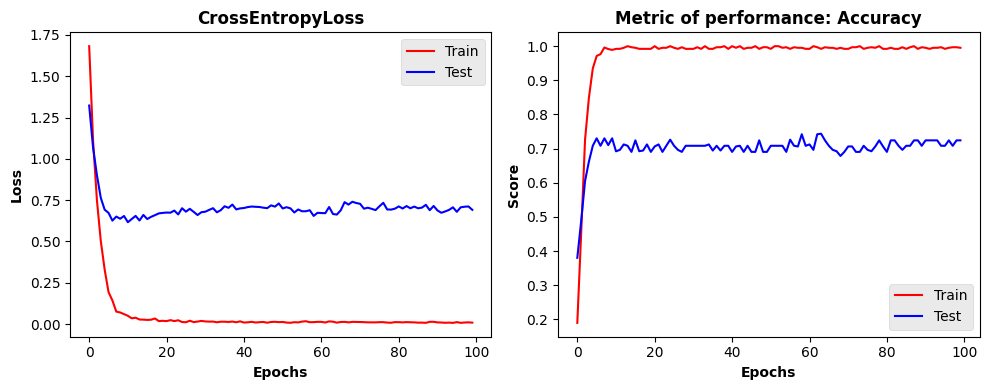

In [124]:
plot_loss_metric_curve(MODEL_RESULTS)

In [125]:
# We load the best model.
import torch
path_checkpoint = "/content/best_model.pt"
!ls {path_checkpoint}
#checkpoint = torch.load(path_checkpoint, map_location=torch.device('cpu'))
checkpoint = torch.load(path_checkpoint)

/content/best_model.pt


In [126]:
# The best model gave us:

print(f'Best test loss = {checkpoint["loss"]}')
print(f'Epoch = {checkpoint["epoch"]+1}')

Best test loss = 0.6163727392752966
Epoch = 11


**Predictions**

In [127]:
import torch
from torchvision import models

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet50 model
model = models.resnet50(pretrained=True)


model.to(device)
# Print the shapes of the parameters in the checkpoint
print(checkpoint["model"]["fc.weight"].shape)
print(checkpoint["model"]["fc.bias"].shape)

# Print the shapes of the parameters in the model
print(model.fc.weight.shape)
print(model.fc.bias.shape)

# Change the output dimension of the fc layer to 7
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(checkpoint["model"])


print(f"Model device: {next(model.parameters()).device}")
print(f"X_train_torch device: {X_train_torch.device}")

model.eval()

# Move the model to the appropriate device
model = model.to('cuda:0')

# Move the input tensors to the same device as the model
X_train_torch = X_train_torch.to('cuda:0')
X_test_torch = X_test_torch.to('cuda:0')
with torch.no_grad():
    y_pred_logits_train = model(X_train_torch)
    y_pred_logits_test = model(X_test_torch)



torch.Size([7, 2048])
torch.Size([7])
torch.Size([1000, 2048])
torch.Size([1000])
Model device: cuda:0
X_train_torch device: cpu


In [128]:
y_pred_prob_train = torch.softmax(y_pred_logits_train, dim = 1).cpu()
y_pred_class_train = torch.argmax(y_pred_prob_train, dim = 1).numpy().astype(int)

y_pred_prob_test = torch.softmax(y_pred_logits_test, dim = 1).cpu()
y_pred_class_test = torch.argmax(y_pred_prob_test, dim = 1).numpy().astype(int)

# **6. Metrics**

**Confusion Matrix**

In [129]:
cf_mx_train = confusion_matrix(y_train_array.astype(int), y_pred_class_train)
cf_mx_test = confusion_matrix(y_test_array.astype(int), y_pred_class_test)

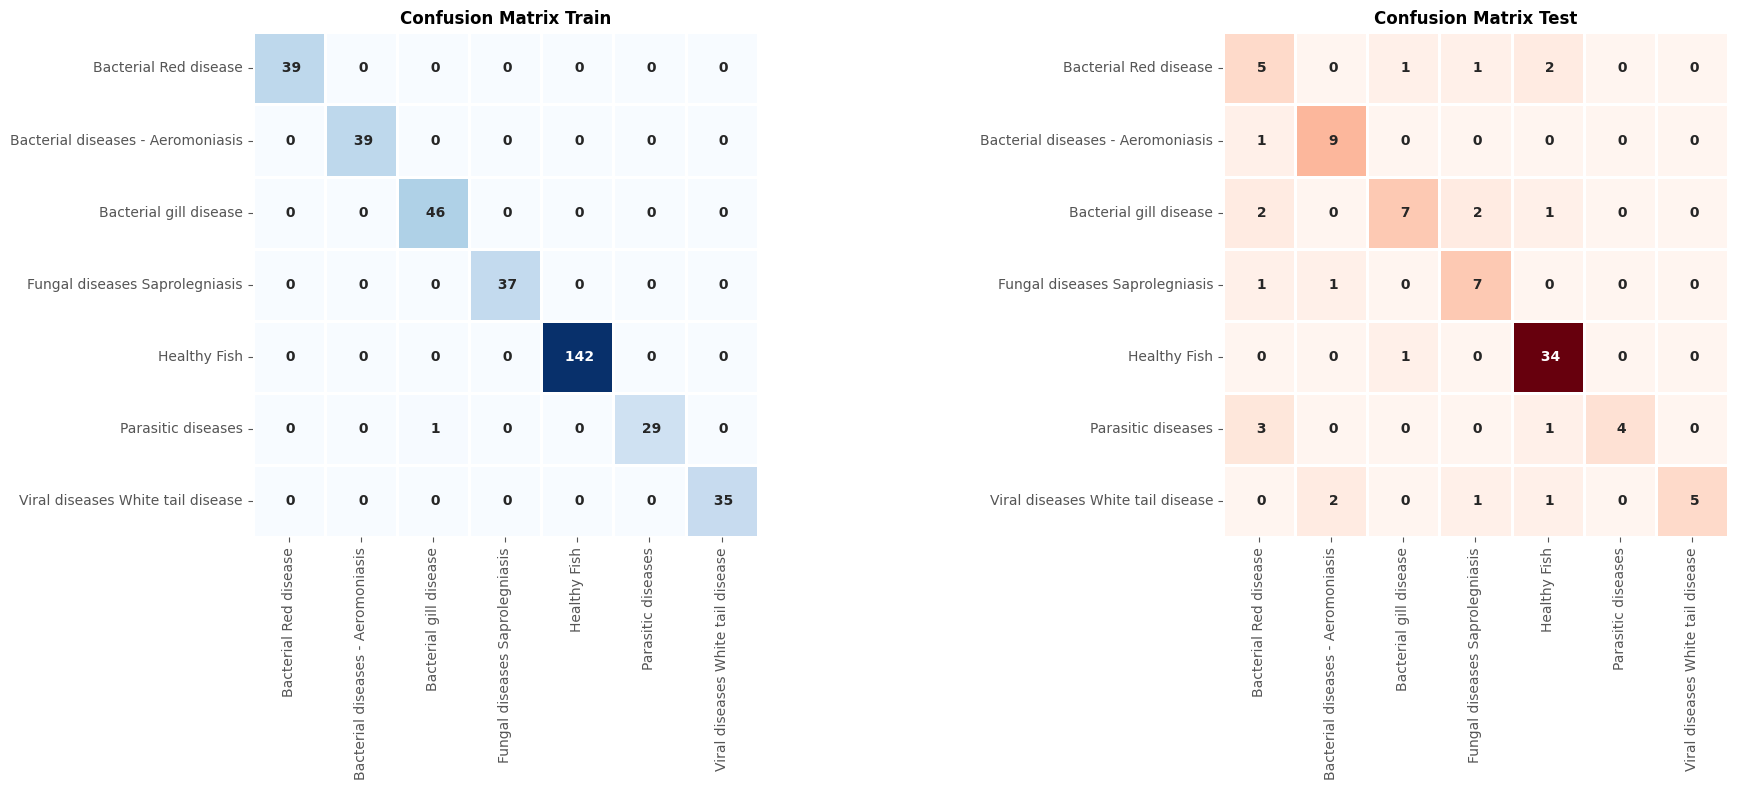

In [130]:
# Confusion Matrix Plot
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax = ax.flat
sns.heatmap(cf_mx_train,
            cmap = 'Blues',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')

sns.heatmap(cf_mx_test,
            cmap = 'Reds',
            annot = True,
            fmt = ' ',
            annot_kws = {"fontsize":10,
                         "fontweight":"bold"},
            linewidths = 1,
            linecolor = "white",
            cbar = False,
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

**Accuray score**

In [131]:
print(f'Accuracy train = {accuracy_score(y_train_array.astype(int), y_pred_class_train)}')

print(f'Accuracy test = {accuracy_score(y_test_array.astype(int), y_pred_class_test)}')

Accuracy train = 0.9972826086956522
Accuracy test = 0.7717391304347826


**Classification Report**

In [132]:
# To perform a reverse mapping, go from id to label.
id2label = dict(zip(range(0,7),classes))
id2label

{0: 'Bacterial Red disease',
 1: 'Bacterial diseases - Aeromoniasis',
 2: 'Bacterial gill disease',
 3: 'Fungal diseases Saprolegniasis',
 4: 'Healthy Fish',
 5: 'Parasitic diseases',
 6: 'Viral diseases White tail disease'}

In [133]:
print("=="*40)
print(" " * 25, "Classification Report Train")
print("=="*40)
print(classification_report(pd.Series(y_train_array).map(id2label),
                            pd.Series(y_pred_class_train).map(id2label),))

print("=="*40)
print(" " * 25, "Classification Report Test")
print("=="*40)
print(classification_report(pd.Series(y_test_array).map(id2label),
                            pd.Series(y_pred_class_test).map(id2label)))

                          Classification Report Train
                                   precision    recall  f1-score   support

            Bacterial Red disease       1.00      1.00      1.00        39
Bacterial diseases - Aeromoniasis       1.00      1.00      1.00        39
           Bacterial gill disease       0.98      1.00      0.99        46
   Fungal diseases Saprolegniasis       1.00      1.00      1.00        37
                     Healthy Fish       1.00      1.00      1.00       142
               Parasitic diseases       1.00      0.97      0.98        30
Viral diseases White tail disease       1.00      1.00      1.00        35

                         accuracy                           1.00       368
                        macro avg       1.00      1.00      1.00       368
                     weighted avg       1.00      1.00      1.00       368

                          Classification Report Test
                                   precision    recall  f1-score 

In [134]:
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib
import pandas as pd
import numpy as np
import os
import glob

import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import seaborn as sn
import numpy as np
import pathlib

In [135]:
BatchSize=32
IMAGE_SIZE=224

In [136]:
IMAGE_PATH=pathlib.Path('/content/SB-FishDisease/SB-FishDisease')
train_ds=train_dataset
val_ds=test_dataset
print(len(val_ds),len(train_ds))
#train_dir = pathlib.Path('../input/brain-image-clean/train')
#test_dir = pathlib.Path('../input/brain-image-clean/test')

#image_count_train = len(list(train_dir.glob('*/*.jpg')))
#image_count_test = len(list(test_dir.glob('*/*.jpg')))
#print("Train Image Count: {} \n Test Image Count: {}".format(image_count_train,image_count_test))

92 368


In [137]:
import os
class_names = sorted(os.listdir(IMAGE_PATH))
class_names

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [138]:
import torch

normalization_layer = torch.nn.functional.normalize

normalized_data = []

for x, y in train_ds:
    normalized_x = normalization_layer(x)
    normalized_data.append((normalized_x, y))



In [143]:
from torch.utils.data import DataLoader

# Assuming train_ds and val_ds are instances of your PyTorch Dataset

# Set batch_size, num_workers, and other DataLoader parameters as needed
batch_size = 4
num_workers = 4

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=False, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=False, shuffle=False)


In [149]:
!kaggle datasets download 'salikhussaini49/brain-image-clean'

 99% 62.0M/62.7M [00:00<00:00, 121MB/s]
100% 62.7M/62.7M [00:00<00:00, 103MB/s]


In [150]:
!unzip brain-image-clean.zip

Archive:  brain-image-clean.zip
  inflating: test/no/No14.jpg        
  inflating: test/no/No15.jpg        
  inflating: test/no/No17.jpg        
  inflating: test/no/no1000.jpg      
  inflating: test/no/no1003.jpg      
  inflating: test/no/no1008.jpg      
  inflating: test/no/no1009.jpg      
  inflating: test/no/no1012.jpg      
  inflating: test/no/no1013.jpg      
  inflating: test/no/no1015.jpg      
  inflating: test/no/no1017.jpg      
  inflating: test/no/no102.jpg       
  inflating: test/no/no1020.jpg      
  inflating: test/no/no1022.jpg      
  inflating: test/no/no1029.jpg      
  inflating: test/no/no103.jpg       
  inflating: test/no/no1031.jpg      
  inflating: test/no/no1033.jpg      
  inflating: test/no/no1034.jpg      
  inflating: test/no/no1037.jpg      
  inflating: test/no/no1039.jpg      
  inflating: test/no/no1040.jpg      
  inflating: test/no/no1042.jpg      
  inflating: test/no/no1043.jpg      
  inflating: test/no/no1046.jpg      
  inflating: test/

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for metric in metrics:
        try:
            name = metric.replace("_", " ").capitalize()
            plt.plot(history['epoch'], history[metric], label='Train')
            plt.plot(history['epoch'], history['val_'+metric], linestyle="--", label='Val')
            plt.xlabel('Epoch')
            plt.ylabel(name)
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            else:
                plt.ylim([0, 1])
            plt.legend()
            plt.show()
        except:
            pass
# Function to perform a validation epoch
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (torch.argmax(outputs, 1) == labels).sum().item()
            total_samples += labels.size(0)

    return total_loss / len(val_loader), total_correct / total_samples
# Function to perform a training epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (torch.argmax(outputs, 1) == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / len(train_loader), total_correct / total_samples

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * seq_height * seq_width, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.pool2(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.batch_norm3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Adjust the dataset path and other parameters accordingly
dataset_path = "/content/SB-FishDisease"
seq_height, seq_width = 224, 224 # Adjust as needed

# Define the transformation with dynamic resizing
transform = transforms.Compose([
    transforms.Resize((seq_height, seq_width)),
    transforms.ToTensor(),
])

# Load the dataset using ImageFolder
full_dataset = ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into train and validation sets
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Define batch size
batch_size = 16

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Rest of the code remains unchanged
# ...


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

# Number of epochs
num_epochs = 16

# Training loop
history = {'epoch': [], 'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation phase
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Record metrics in history
    history['epoch'].append(epoch + 1)
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    # Print epoch metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plotting the metrics
plot_metrics(history)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same